In [1]:
%pip install kaggle

In [3]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

# Paths and dataset config
kaggle_json_path = '/content/kaggle.json'
dataset_name = 'kartik2112/fraud-detection'
download_dir = 'fraud_dataset'

try:
    # Load Kaggle credentials
    with open(kaggle_json_path, 'r') as f:
        creds = json.load(f)
    username, key = creds.get('username'), creds.get('key')
    if not username or not key:
        raise ValueError("Missing 'username' or 'key' in kaggle.json.")

    # Set environment variables for Kaggle API authentication
    os.environ['KAGGLE_USERNAME'] = username
    os.environ['KAGGLE_KEY'] = key

    # Authenticate and download dataset
    api = KaggleApi()
    api.authenticate()

    os.makedirs(download_dir, exist_ok=True)
    api.dataset_download_files(dataset_name, path=download_dir, unzip=True)

    print(f"✅ Dataset '{dataset_name}' downloaded and unzipped to '{download_dir}'.")

except FileNotFoundError:
    print(f"❌ Error: '{kaggle_json_path}' not found.")
except json.JSONDecodeError:
    print(f"❌ Error: Invalid JSON in '{kaggle_json_path}'.")
except ValueError as ve:
    print(f"❌ {ve}")
except Exception as e:
    print(f"❌ Unexpected error: {e}")


Dataset URL: https://www.kaggle.com/datasets/kartik2112/fraud-detection
✅ Dataset 'kartik2112/fraud-detection' downloaded and unzipped to 'fraud_dataset'.


🚀 Starting Complete Credit Card Fraud Detection Analysis
✅ Dataset loaded successfully from /content/fraud_dataset/fraudTrain.csv: (1296675, 23)
✅ Renamed target column 'is_fraud' to 'Class'
📊 EXPLORATORY DATA ANALYSIS
Dataset Info:
  Shape: (1296675, 23)
  Total transactions: 1,296,675
  Fraudulent transactions: 7,506
  Fraud percentage: 0.58%
  Missing values: 0


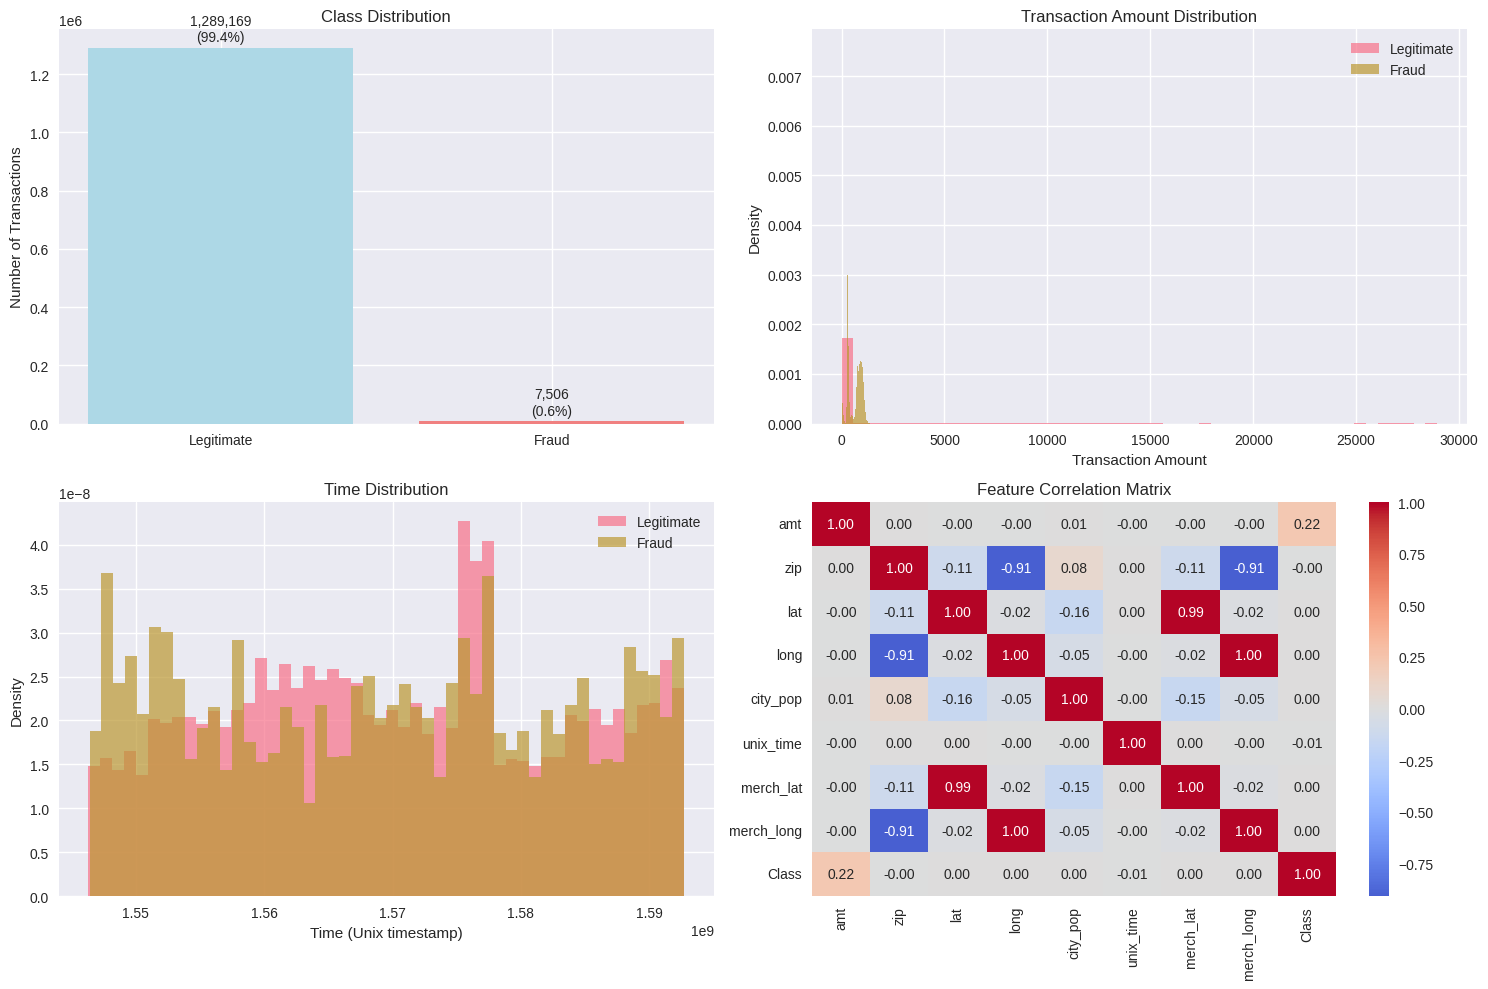


📈 Summary Statistics:
          amt                         trans_date_trans_time             
         mean     std   min       max                  mean          std
Class                                                                   
0       67.67  154.01  1.00  28948.90          1.570112e+09  12849345.92
1      531.32  390.56  1.06   1376.04          1.569258e+09  13838479.40
🔧 DATA PREPROCESSING
📏 Scaling features...
✂️ Splitting data...
  Training set: (1037340, 9)
  Test set: (259335, 9)
  Training fraud rate: 0.0058
  Test fraud rate: 0.0058
🤖 INITIALIZING MODELS
✅ Initialized 3 models:
  • Logistic Regression
  • Decision Tree
  • Random Forest
🏋️ TRAINING MODELS
📊 MODEL EVALUATION
📈 Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC  CV AUC
0  Logistic Regression    0.9518     0.0861  0.7615    0.1547  0.8335  0.8288
1        Decision Tree    0.9052     0.0499  0.8528    0.0943  0.9382  0.9373
2        Random Forest    0.9627     0.11

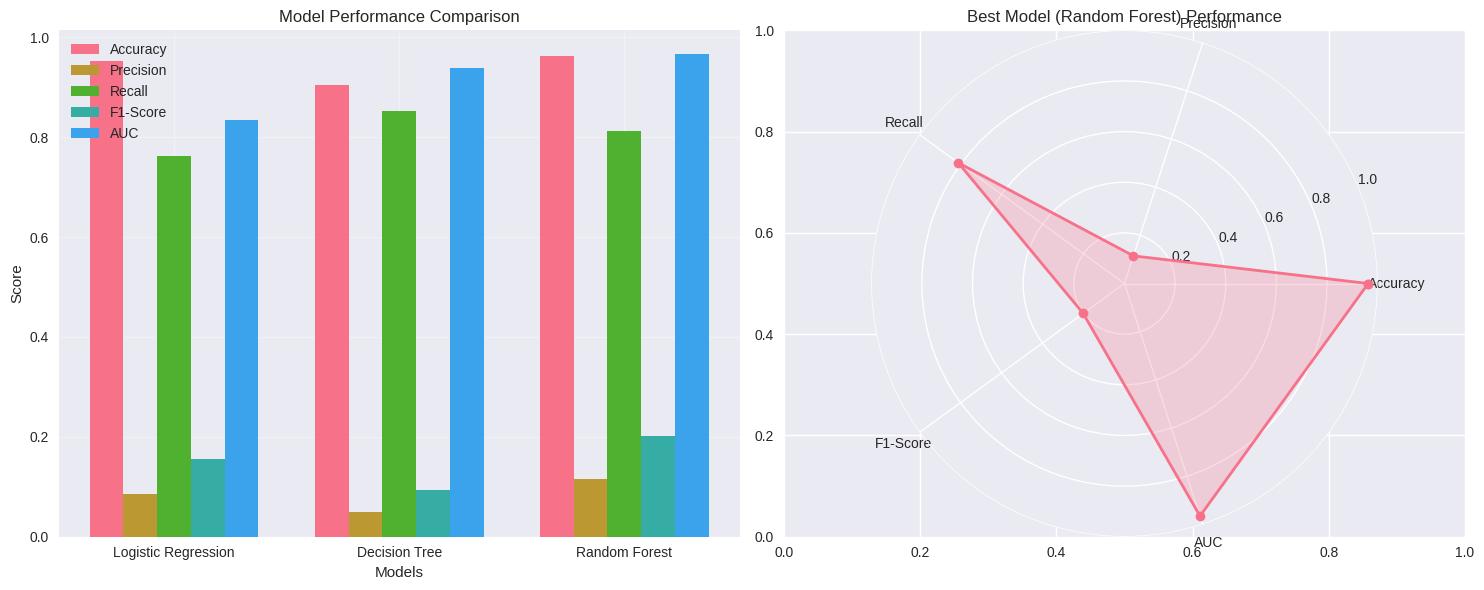

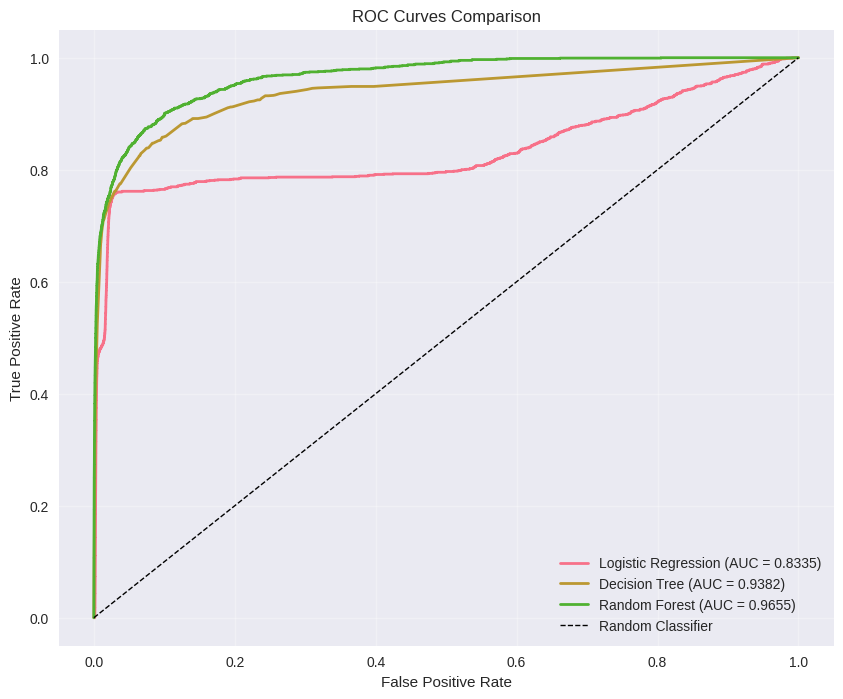

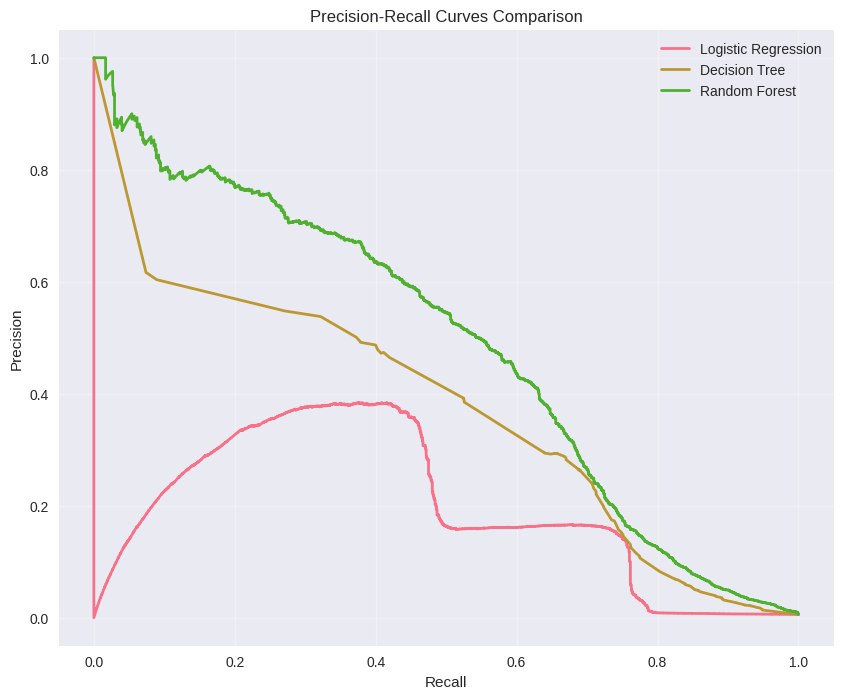

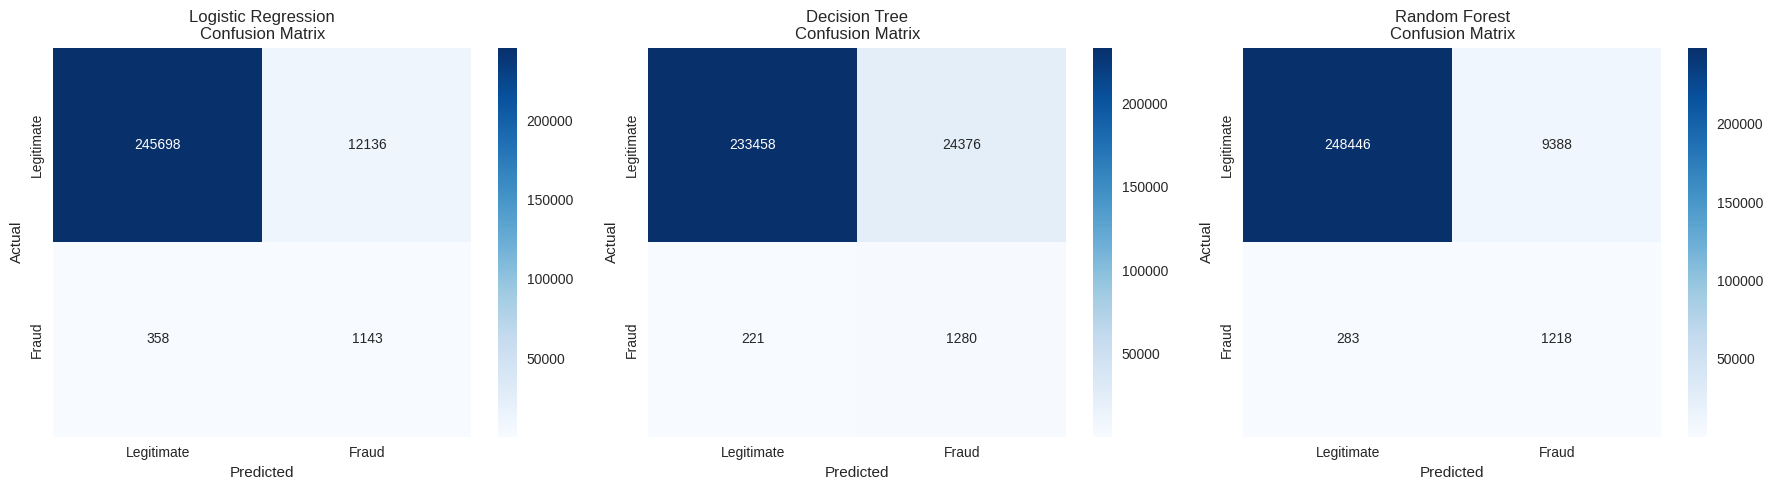

🔍 FEATURE IMPORTANCE ANALYSIS


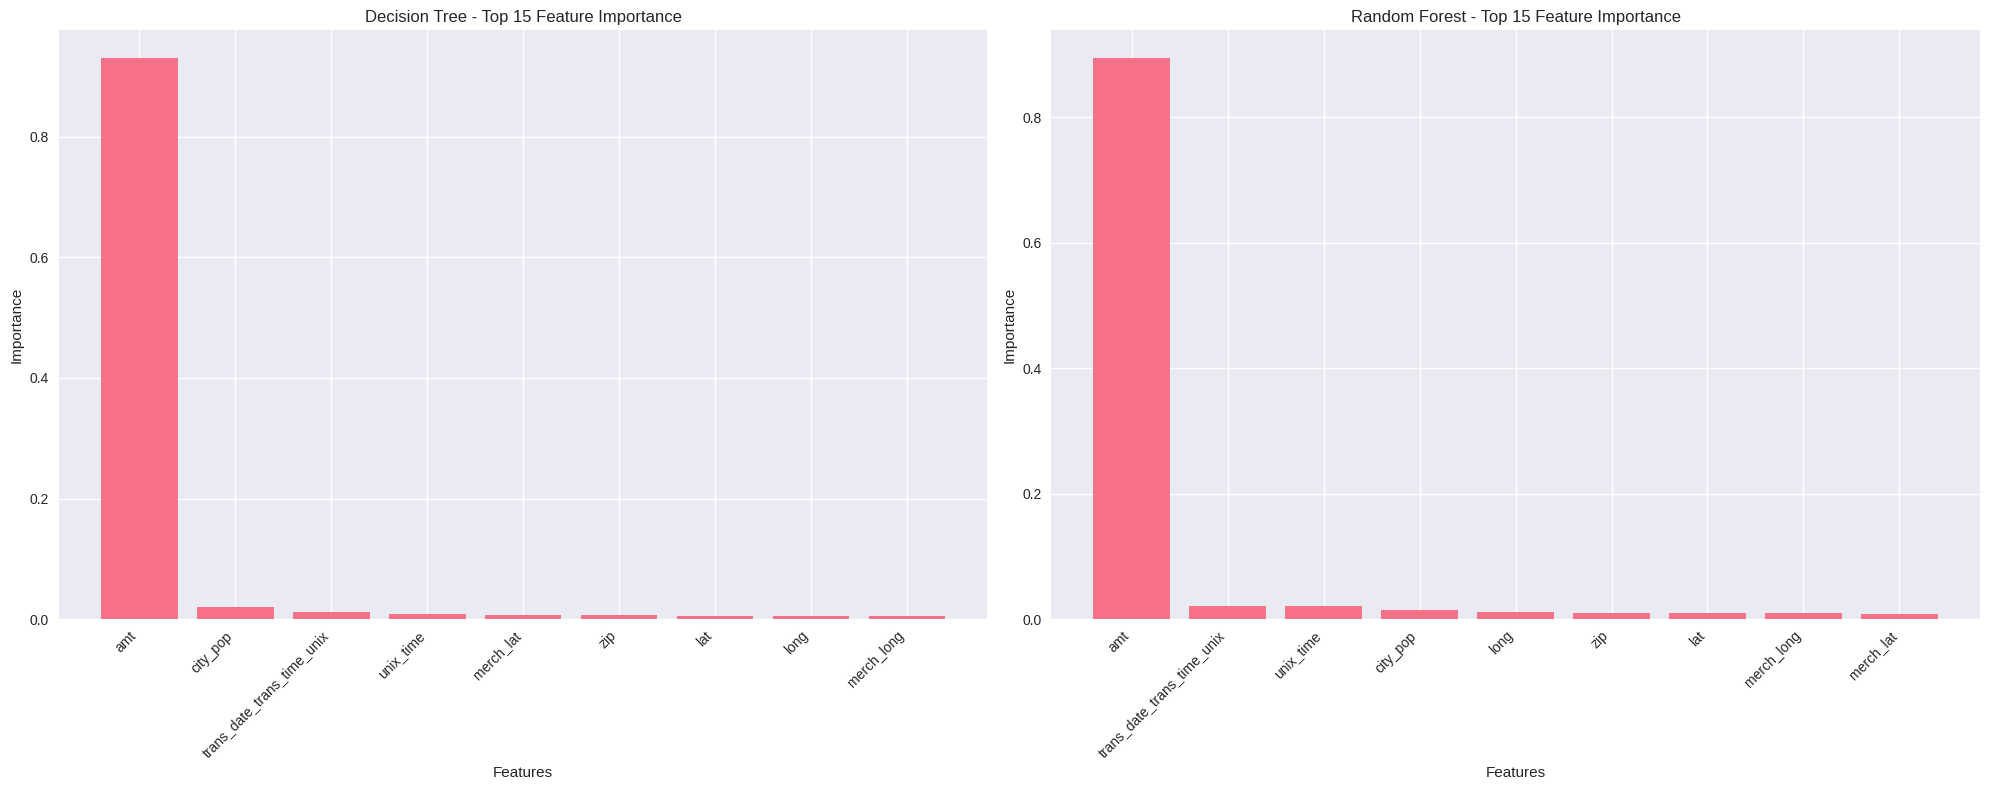

🌲 Top 10 Most Important Features (Random Forest):
  1. amt: 0.8942
  2. trans_date_trans_time_unix: 0.0217
  3. unix_time: 0.0206
  4. city_pop: 0.0142
  5. long: 0.0106
  6. zip: 0.0105
  7. lat: 0.0104
  8. merch_long: 0.0092
  9. merch_lat: 0.0087
📋 DETAILED CLASSIFICATION REPORT

Logistic Regression:
----------------------------------------
              precision    recall  f1-score   support

  Legitimate       1.00      0.95      0.98    257834
       Fraud       0.09      0.76      0.15      1501

    accuracy                           0.95    259335
   macro avg       0.54      0.86      0.56    259335
weighted avg       0.99      0.95      0.97    259335


Decision Tree:
----------------------------------------
              precision    recall  f1-score   support

  Legitimate       1.00      0.91      0.95    257834
       Fraud       0.05      0.85      0.09      1501

    accuracy                           0.91    259335
   macro avg       0.52      0.88      0.52    2593

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score,
    roc_curve, precision_recall_curve
)
import warnings
from joblib import Parallel, delayed
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class CreditCardFraudDetector:
    """
    Simple Credit Card Fraud Detection using Logistic Regression, Decision Trees, and Random Forest
    """

    def __init__(self):
        self.models = {}
        self.results = {}
        self.scaler = StandardScaler()
        self.best_model = None
        self.best_model_name = None
        self.data = None # Initialize data attribute
        self.target_column = 'is_fraud' # Define the target column name
        self.time_column = 'trans_date_trans_time' # Define the time column name
        self.amount_column = 'amt' # Define the amount column name


    def load_data(self, file_path=None):
        """Load credit card fraud dataset"""
        if file_path:
            try:
                self.data = pd.read_csv(file_path)
                print(f"✅ Dataset loaded successfully from {file_path}: {self.data.shape}")
                # Check if the specified target column exists
                if self.target_column not in self.data.columns:
                    print(f"❌ Error: Target column '{self.target_column}' not found in the dataset.")
                    print("📊 Creating sample dataset instead...")
                    self.create_sample_data()
                else:
                    # Rename the target column to 'Class' for consistency with the rest of the code
                    self.data = self.data.rename(columns={self.target_column: 'Class'})
                    print(f"✅ Renamed target column '{self.target_column}' to 'Class'")

                    # Convert time column to datetime and extract relevant features if needed
                    if self.time_column in self.data.columns:
                        self.data[self.time_column] = pd.to_datetime(self.data[self.time_column])
                        # Example: Extract hour of the day as a feature
                        # self.data['hour'] = self.data[self.time_column].dt.hour
                        # Example: Extract day of the week as a feature
                        # self.data['dayofweek'] = self.data[self.time_column].dt.dayofweek
                    else:
                        print(f"⚠️ Time column '{self.time_column}' not found in the dataset.")


            except FileNotFoundError:
                print(f"❌ Error: File not found at {file_path}.")
                print("📊 Creating sample dataset instead...")
                self.create_sample_data()
            except Exception as e:
                print(f"❌ Error loading dataset from {file_path}: {e}")
                print("📊 Creating sample dataset instead...")
                self.create_sample_data()
        else:
            print("📊 Creating sample dataset for demonstration...")
            self.create_sample_data()

        return self.data


    def create_sample_data(self):
        """Create sample credit card transaction data"""
        np.random.seed(42)

        # Generate synthetic credit card transaction data
        n_samples = 10000

        # Generate features similar to real credit card data
        # Time feature (seconds from first transaction)
        time = np.random.uniform(0, 172800, n_samples)  # 48 hours

        # Amount feature (transaction amounts)
        amount = np.random.exponential(scale=50, size=n_samples)

        # V1-V28 features (anonymized features from PCA)
        v_features = np.random.randn(n_samples, 28)

        # Create target variable (fraud vs legitimate)
        # Most transactions are legitimate (99.8%)
        fraud_probability = 0.002
        is_fraud = np.random.binomial(1, fraud_probability, n_samples)

        # Make fraudulent transactions have different patterns
        fraud_indices = np.where(is_fraud == 1)[0]

        # Fraudulent transactions tend to have:
        # - Higher amounts
        amount[fraud_indices] *= np.random.uniform(2, 5, len(fraud_indices))

        # - Different V feature patterns
        v_features[fraud_indices] += np.random.normal(0, 2, (len(fraud_indices), 28))

        # Create DataFrame
        columns = ['Time', 'Amount'] + [f'V{i}' for i in range(1, 29)] + ['Class']
        data = np.column_stack([time, amount, v_features, is_fraud])

        self.data = pd.DataFrame(data, columns=columns)
        print(f"✅ Sample dataset created: {self.data.shape}")

    def explore_data(self):
        """Explore the dataset"""
        if self.data is None:
            print("❌ Data not loaded. Please run load_data first.")
            return

        print("=" * 60)
        print("📊 EXPLORATORY DATA ANALYSIS")
        print("=" * 60)

        # Basic statistics
        print("Dataset Info:")
        print(f"  Shape: {self.data.shape}")
        print(f"  Total transactions: {len(self.data):,}")

        # Check if 'Class' column exists before accessing
        if 'Class' in self.data.columns:
            print(f"  Fraudulent transactions: {self.data['Class'].sum():,}")
            print(f"  Fraud percentage: {(self.data['Class'].sum() / len(self.data)) * 100:.2f}%")
        else:
            print("❌ 'Class' column not found for fraud statistics.")


        print(f"  Missing values: {self.data.isnull().sum().sum()}")

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. Class distribution
        if 'Class' in self.data.columns:
            class_counts = self.data['Class'].value_counts()
            axes[0, 0].bar(['Legitimate', 'Fraud'], class_counts.values.astype(int), color=['lightblue', 'lightcoral']) # Ensure counts are int
            axes[0, 0].set_title('Class Distribution')
            axes[0, 0].set_ylabel('Number of Transactions')

            # Add percentage labels
            for i, v in enumerate(class_counts.values):
                axes[0, 0].text(i, v + len(self.data) * 0.01, f'{int(v):,}\n({v/len(self.data)*100:.1f}%)', # Ensure counts are int
                               ha='center', va='bottom')
        else:
            axes[0, 0].set_title('Class Distribution (Not Available)')
            axes[0, 0].text(0.5, 0.5, 'Class column not found', horizontalalignment='center', verticalalignment='center', transform=axes[0, 0].transAxes)


        # 2. Transaction amount distribution
        if self.amount_column in self.data.columns and 'Class' in self.data.columns:
             # Ensure 'Class' column is integer type for boolean indexing
            self.data['Class'] = self.data['Class'].astype(int)

            fraud_amounts = self.data[self.data['Class'] == 1][self.amount_column]
            legit_amounts = self.data[self.data['Class'] == 0][self.amount_column]

            axes[0, 1].hist(legit_amounts, bins=50, alpha=0.7, label='Legitimate', density=True)
            axes[0, 1].hist(fraud_amounts, bins=50, alpha=0.7, label='Fraud', density=True)
            axes[0, 1].set_xlabel('Transaction Amount')
            axes[0, 1].set_ylabel('Density')
            axes[0, 1].set_title('Transaction Amount Distribution')
            axes[0, 1].legend()
        else:
            axes[0, 1].set_title('Transaction Amount Distribution (Not Available)')
            axes[0, 1].text(0.5, 0.5, f"'{self.amount_column}' or 'Class' column not found", horizontalalignment='center', verticalalignment='center', transform=axes[0, 1].transAxes)


        # 3. Time distribution
        if self.time_column in self.data.columns and 'Class' in self.data.columns:
             # Ensure 'Class' column is integer type for boolean indexing
            self.data['Class'] = self.data['Class'].astype(int)

            fraud_time = self.data[self.data['Class'] == 1][self.time_column].astype(np.int64) // 10**9 # Convert datetime to Unix timestamp
            legit_time = self.data[self.data['Class'] == 0][self.time_column].astype(np.int64) // 10**9 # Convert datetime to Unix timestamp

            axes[1, 0].hist(legit_time, bins=50, alpha=0.7, label='Legitimate', density=True)
            axes[1, 0].hist(fraud_time, bins=50, alpha=0.7, label='Fraud', density=True)
            axes[1, 0].set_xlabel('Time (Unix timestamp)') # Update label
            axes[1, 0].set_ylabel('Density')
            axes[1, 0].set_title('Time Distribution')
            axes[1, 0].legend()
        else:
            axes[1, 0].set_title('Time Distribution (Not Available)')
            axes[1, 0].text(0.5, 0.5, f"'{self.time_column}' or 'Class' column not found", horizontalalignment='center', verticalalignment='center', transform=axes[1, 0].transAxes)


        # 4. Correlation matrix (sample of features)
        # Identify numerical columns for correlation matrix, excluding identifier and target columns
        numerical_cols = self.data.select_dtypes(include=np.number).columns.tolist()
        exclude_cols = ['Unnamed: 0', 'cc_num', 'trans_num', 'Class'] # Exclude identifier and target
        correlation_features = [col for col in numerical_cols if col not in exclude_cols]

        # Include 'Class' in correlation features if it exists
        if 'Class' in self.data.columns:
            correlation_features.append('Class')


        if correlation_features:
            correlation_matrix = self.data[correlation_features].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 1], fmt=".2f") # Format annotations
            axes[1, 1].set_title('Feature Correlation Matrix')
        else:
             axes[1, 1].set_title('No correlation features available')
             axes[1, 1].text(0.5, 0.5, 'No numerical features for correlation plot', horizontalalignment='center', verticalalignment='center', transform=axes[1, 1].transAxes)


        plt.tight_layout()
        plt.show()

        # Summary statistics
        print("\n📈 Summary Statistics:")
        if 'Class' in self.data.columns and self.amount_column in self.data.columns and self.time_column in self.data.columns:
            # Ensure 'Class' column is integer type before grouping
            self.data['Class'] = self.data['Class'].astype(int)

            # Convert time column to Unix timestamp for summary statistics if it exists
            if self.time_column in self.data.columns:
                 temp_data = self.data.copy()
                 temp_data[self.time_column] = temp_data[self.time_column].astype(np.int64) // 10**9
                 print(temp_data.groupby('Class').agg({
                    self.amount_column: ['mean', 'std', 'min', 'max'],
                    self.time_column: ['mean', 'std']
                }).round(2))
            else:
                 print(self.data.groupby('Class').agg({
                    self.amount_column: ['mean', 'std', 'min', 'max']
                }).round(2))

        else:
            print("❌ Cannot generate summary statistics: 'Class', 'Amount' or 'Time' column not found.")


    def preprocess_data(self):
        """Preprocess the data for modeling"""
        if self.data is None:
            print("❌ Data not loaded. Please run load_data first.")
            return None, None, None, None

        print("=" * 60)
        print("🔧 DATA PREPROCESSING")
        print("=" * 60)

        # Separate features and target
        # Ensure 'Class' column is present before dropping
        if 'Class' not in self.data.columns:
             print("❌ 'Class' column not found in the dataset after loading/renaming.")
             return None, None, None, None

        y = self.data['Class'].astype(int) # Ensure target is integer type

        # Select features: all numerical columns except identifier columns and the target column
        numerical_cols = self.data.select_dtypes(include=np.number).columns.tolist()
        exclude_cols = ['Unnamed: 0', 'cc_num', 'trans_num', 'Class'] # Exclude identifier and target
        feature_cols = [col for col in numerical_cols if col not in exclude_cols]

        # Include 'amt' and convert 'trans_date_trans_time' to numerical representation if they exist
        if self.amount_column in self.data.columns and self.amount_column not in feature_cols:
            feature_cols.append(self.amount_column)

        if self.time_column in self.data.columns:
             # Convert datetime to Unix timestamp for numerical processing
             self.data[self.time_column + '_unix'] = self.data[self.time_column].astype(np.int64) // 10**9
             if self.time_column + '_unix' not in feature_cols:
                 feature_cols.append(self.time_column + '_unix')


        X = self.data[feature_cols]


        # Scale the features (important for Logistic Regression)
        print("📏 Scaling features...")
        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        # Split the data
        print("✂️ Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        print(f"  Training set: {X_train.shape}")
        print(f"  Test set: {X_test.shape}")
        print(f"  Training fraud rate: {y_train.mean():.4f}")
        print(f"  Test fraud rate: {y_test.mean():.4f}")

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        return X_train, X_test, y_train, y_test

    def initialize_models(self):
        """Initialize the three main algorithms"""
        print("=" * 60)
        print("🤖 INITIALIZING MODELS")
        print("=" * 60)

        # 1. Logistic Regression
        self.models['Logistic Regression'] = LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight='balanced'  # Handle class imbalance
        )

        # 2. Decision Tree
        self.models['Decision Tree'] = DecisionTreeClassifier(
            random_state=42,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced'
        )

        # 3. Random Forest
        self.models['Random Forest'] = RandomForestClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            class_weight='balanced'
        )

        print(f"✅ Initialized {len(self.models)} models:")
        for name in self.models.keys():
            print(f"  • {name}")

    def train_single_model(self, name, model, X_train, y_train, X_test, y_test):
        """Helper function to train and evaluate a single model"""
        print(f"\n🚀 Training {name}...")
        result = {}
        try:
            # Train the model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred_proba)

            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

            # Store results
            result = {
                'model': model,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc_score': auc,
                'cv_auc_mean': cv_scores.mean(),
                'cv_auc_std': cv_scores.std(),
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }

            print(f"  ✅ {name} trained successfully")
            print(f"     Accuracy: {accuracy:.4f}")
            print(f"     Precision: {precision:.4f}")
            print(f"     Recall: {recall:.4f}")
            print(f"     F1-Score: {f1:.4f}")
            print(f"     AUC: {auc:.4f}")
            print(f"     CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

        except Exception as e:
            print(f"❌ Error training {name}: {e}")

        return name, result


    def train_models(self):
        """Train all models in parallel"""
        if not hasattr(self, 'X_train') or self.X_train is None:
            print("❌ Data not preprocessed. Please run preprocess_data first.")
            return

        print("=" * 60)
        print("🏋️ TRAINING MODELS")
        print("=" * 60)

        self.results = {}

        # Train models in parallel
        results = Parallel(n_jobs=-1)(
            delayed(self.train_single_model)(name, model, self.X_train, self.y_train, self.X_test, self.y_test)
            for name, model in self.models.items()
        )

        # Store results from parallel execution
        for name, result in results:
            if result: # Only store if training was successful
                self.results[name] = result


    def evaluate_models(self):
        """Evaluate and compare all models"""
        if not self.results:
            print("❌ Models not trained. Please run train_models first.")
            return None

        print("=" * 60)
        print("📊 MODEL EVALUATION")
        print("=" * 60)

        # Create comparison table
        comparison_data = []
        for name, result in self.results.items():
            comparison_data.append({
                'Model': name,
                'Accuracy': result['accuracy'],
                'Precision': result['precision'],
                'Recall': result['recall'],
                'F1-Score': result['f1_score'],
                'AUC': result['auc_score'],
                'CV AUC': result['cv_auc_mean']
            })

        comparison_df = pd.DataFrame(comparison_data)
        print("📈 Model Comparison:")
        print(comparison_df.round(4))

        # Find best model based on AUC score
        if not comparison_df.empty:
            best_idx = comparison_df['AUC'].idxmax()
            self.best_model_name = comparison_df.loc[best_idx, 'Model']
            self.best_model = self.results[self.best_model_name]['model']
            print(f"\n🏆 Best Model: {self.best_model_name} (AUC: {comparison_df.loc[best_idx, 'AUC']:.4f})")
        else:
            self.best_model_name = None
            self.best_model = None
            print("\n❌ No models successfully trained or evaluated.")


        # Create visualizations
        if not comparison_df.empty:
            self.plot_model_comparison()
            self.plot_roc_curves()
            self.plot_precision_recall_curves()
            self.plot_confusion_matrices()
        else:
             print("❌ Cannot plot evaluation metrics as no models were evaluated successfully.")


        return comparison_df

    def plot_model_comparison(self):
        """Plot model comparison metrics"""
        if not self.results:
            print("❌ No results available for plotting model comparison.")
            return

        # Prepare data for plotting
        models = list(self.results.keys())
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_score']
        metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Bar plot of all metrics
        x = np.arange(len(models))
        width = 0.15

        for i, (metric, label) in enumerate(zip(metrics, metric_labels)):
            values = [self.results[model].get(metric, 0) for model in models] # Use .get for safety
            axes[0].bar(x + i * width, values, width, label=label)

        axes[0].set_xlabel('Models')
        axes[0].set_ylabel('Score')
        axes[0].set_title('Model Performance Comparison')
        axes[0].set_xticks(x + width * 2)
        axes[0].set_xticklabels(models)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Radar chart for best model
        if self.best_model_name and self.best_model_name in self.results:
            angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
            angles += angles[:1]  # Complete the circle

            best_values = [self.results[self.best_model_name].get(metric, 0) for metric in metrics] # Use .get for safety
            best_values += best_values[:1]  # Complete the circle

            axes[1] = plt.subplot(1, 2, 2, projection='polar')
            axes[1].plot(angles, best_values, 'o-', linewidth=2, label=self.best_model_name)
            axes[1].fill(angles, best_values, alpha=0.25)
            axes[1].set_xticks(angles[:-1])
            axes[1].set_xticklabels(metric_labels)
            axes[1].set_ylim(0, 1)
            axes[1].set_title(f'Best Model ({self.best_model_name}) Performance')
            axes[1].grid(True)
        else:
            axes[1].set_title('Radar Chart (No best model selected)')


        plt.tight_layout()
        plt.show()

    def plot_roc_curves(self):
        """Plot ROC curves for all models"""
        if not self.results:
            print("❌ No results available for plotting ROC curves.")
            return

        plt.figure(figsize=(10, 8))

        for name, result in self.results.items():
            if 'y_pred_proba' in result: # Check if probabilities are available
                fpr, tpr, _ = roc_curve(self.y_test, result['y_pred_proba'])
                auc_score = result.get('auc_score', 0) # Use .get for safety
                plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.4f})')
            else:
                print(f"⚠️ No probability predictions for {name}, skipping ROC curve.")


        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_precision_recall_curves(self):
        """Plot Precision-Recall curves for all models"""
        if not self.results:
            print("❌ No results available for plotting Precision-Recall curves.")
            return

        plt.figure(figsize=(10, 8))

        for name, result in self.results.items():
             if 'y_pred_proba' in result: # Check if probabilities are available
                precision, recall, _ = precision_recall_curve(self.y_test, result['y_pred_proba'])
                plt.plot(recall, precision, linewidth=2, label=f'{name}')
             else:
                 print(f"⚠️ No probability predictions for {name}, skipping Precision-Recall curve.")


        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        if not self.results:
            print("❌ No results available for plotting confusion matrices.")
            return

        fig, axes = plt.subplots(1, len(self.results), figsize=(6 * len(self.results), 5))

        # Adjust axes if only one model is trained
        if len(self.results) == 1:
            axes = [axes]

        for i, (name, result) in enumerate(self.results.items()):
            if 'y_pred' in result: # Check if predictions are available
                cm = confusion_matrix(self.y_test, result['y_pred'])

                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
                axes[i].set_title(f'{name}\nConfusion Matrix')
                axes[i].set_xlabel('Predicted')
                axes[i].set_ylabel('Actual')
                axes[i].set_xticklabels(['Legitimate', 'Fraud'])
                axes[i].set_yticklabels(['Legitimate', 'Fraud'])
            else:
                 axes[i].set_title(f'{name}\nNo Predictions Available')
                 axes[i].text(0.5, 0.5, 'No predictions for confusion matrix', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)


        plt.tight_layout()
        plt.show()


    def analyze_feature_importance(self):
        """Analyze feature importance for tree-based models"""
        if not hasattr(self, 'X_train') or self.X_train is None:
            print("❌ Data not preprocessed. Cannot analyze feature importance.")
            return

        print("=" * 60)
        print("🔍 FEATURE IMPORTANCE ANALYSIS")
        print("=" * 60)

        # Get feature names
        feature_names = self.X_train.columns

        # Plot feature importance for tree-based models
        tree_models = ['Decision Tree', 'Random Forest']

        # Filter for models that were trained successfully
        trained_tree_models = [model_name for model_name in self.results if model_name in tree_models]


        if not trained_tree_models:
            print("❌ No tree-based models were trained successfully.")
            return

        fig, axes = plt.subplots(1, len(trained_tree_models), figsize=(10 * len(trained_tree_models), 8))

        # Adjust axes if only one tree-based model is trained
        if len(trained_tree_models) == 1:
            axes = [axes]


        for i, model_name in enumerate(trained_tree_models):
            model = self.results[model_name]['model']
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_

                # Get top 15 features
                indices = np.argsort(importance)[::-1][:15]

                axes[i].bar(range(len(indices)), importance[indices])
                axes[i].set_title(f'{model_name} - Top 15 Feature Importance')
                axes[i].set_xlabel('Features')
                axes[i].set_ylabel('Importance')
                axes[i].set_xticks(range(len(indices)))
                axes[i].set_xticklabels([feature_names[j] for j in indices], rotation=45, ha='right') # Adjust ha for readability
            else:
                 axes[i].set_title(f'{model_name}\nFeature Importance Not Available')
                 axes[i].text(0.5, 0.5, 'Model does not have feature_importances_', horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)


        plt.tight_layout()
        plt.show()

        # Print top features for Random Forest
        if 'Random Forest' in self.results and hasattr(self.results['Random Forest']['model'], 'feature_importances_'):
            rf_model = self.results['Random Forest']['model']
            importance = rf_model.feature_importances_
            indices = np.argsort(importance)[::-1]

            print("🌲 Top 10 Most Important Features (Random Forest):")
            for i in range(min(10, len(indices))):
                print(f"  {i+1}. {feature_names[indices[i]]}: {importance[indices[i]]:.4f}")

        elif 'Random Forest' not in self.results:
             print("❌ Random Forest model was not trained.")
        else: # Random Forest is in results but no feature_importances_
             print("❌ Random Forest model does not have feature_importances_ attribute.")


    def get_detailed_report(self):
        """Generate detailed classification report"""
        if not self.results:
            print("❌ No results available for detailed classification report.")
            return

        print("=" * 60)
        print("📋 DETAILED CLASSIFICATION REPORT")
        print("=" * 60)

        for name, result in self.results.items():
            if 'y_pred' in result:
                print(f"\n{name}:")
                print("-" * 40)
                print(classification_report(self.y_test, result['y_pred'],
                                        target_names=['Legitimate', 'Fraud']))
            else:
                print(f"\n{name}: No predictions available for classification report.")


    def predict_new_transaction(self, transaction_data):
        """Predict if a new transaction is fraudulent"""
        if self.best_model is None:
            print("❌ No trained model available. Please train models first.")
            return None

        # Ensure transaction_data is in the correct format (e.g., a list or numpy array)
        # and has the correct number of features
        if not hasattr(self, 'X_train') or self.X_train is None:
             print("❌ Training data not available to determine feature count.")
             return None

        # Check if the number of features matches the trained model
        expected_features = len(self.X_train.columns)
        if len(transaction_data) != expected_features:
            print(f"❌ Invalid number of features. Expected {expected_features}, but got {len(transaction_data)}.")
            return None

        try:
            # Scale the transaction data
            # Reshape for single sample prediction
            transaction_scaled = self.scaler.transform(np.array(transaction_data).reshape(1, -1))

            # Make prediction
            prediction = self.best_model.predict(transaction_scaled)[0]
            probability = self.best_model.predict_proba(transaction_scaled)[0, 1]

            result = {
                'prediction': 'Fraud' if prediction == 1 else 'Legitimate',
                'fraud_probability': probability,
                'confidence': max(probability, 1 - probability)
            }

            return result
        except Exception as e:
            print(f"❌ Error during prediction: {e}")
            return None


    def run_complete_analysis(self, file_path=None):
        """Run the complete fraud detection analysis"""
        print("🚀 Starting Complete Credit Card Fraud Detection Analysis")
        print("=" * 80)

        # 1. Load data
        self.load_data(file_path)

        # Check if data was loaded before proceeding
        # Also check if the 'Class' column exists after loading and renaming
        if self.data is None or self.data.empty or 'Class' not in self.data.columns:
             print("❌ Data loading failed or target column not found. Analysis stopped.")
             return None


        # 2. Explore data
        self.explore_data()

        # 3. Preprocess data
        X_train, X_test, y_train, y_test = self.preprocess_data()

        # Check if preprocessing was successful before proceeding
        if X_train is None:
             print("❌ Data preprocessing failed. Analysis stopped.")
             return None

        # 4. Initialize models
        self.initialize_models()

        # 5. Train models
        self.train_models()

        # Check if any models were trained successfully before proceeding
        if not self.results:
             print("❌ No models were trained successfully. Analysis stopped.")
             return None

        # 6. Evaluate models
        comparison_df = self.evaluate_models()

        # Check if evaluation was successful before proceeding
        if comparison_df is None:
             print("❌ Model evaluation failed. Analysis stopped.")
             return None


        # 7. Analyze feature importance
        self.analyze_feature_importance()

        # 8. Get detailed report
        self.get_detailed_report()

        print("\n" + "=" * 80)
        print("✅ Analysis Complete!")
        print(f"🏆 Best performing model: {self.best_model_name}")
        print("=" * 80)

        return comparison_df

# Example usage (will still use sample data unless file_path is provided)
if __name__ == "__main__":
    # Create detector instance
    detector = CreditCardFraudDetector()

    # Option 1: Run with your own dataset
    # Replace 'fraud_dataset/creditcard.csv' with the actual path after download
    results = detector.run_complete_analysis('/content/fraud_dataset/fraudTrain.csv')

    # Option 2: Run with sample data
    # results = detector.run_complete_analysis()

    # Example of predicting a new transaction
    # Note: This would be a real transaction with all 30 features
    # Ensure you have X_train defined from preprocessing to get the correct number of features
    # if hasattr(detector, 'X_train') and detector.X_train is not None:
    #     # Create a sample transaction with the same number of features as the training data
    #     sample_transaction = np.random.randn(len(detector.X_train.columns))
    #     prediction = detector.predict_new_transaction(sample_transaction)

    #     if prediction:
    #         print(f"\n🔍 Sample Transaction Prediction:")
    #         print(f"   Result: {prediction['prediction']}")
    #         print(f"   Fraud Probability: {prediction['fraud_probability']:.4f}")
    #         print(f"   Confidence: {prediction['confidence']:.4f}")
    # else:
    #     print("\n⚠️ Cannot run sample transaction prediction: Data not loaded or preprocessed successfully.")

In [5]:
import os

# Define the directory name
model_directory = "fraud_detection_models"

# Create the directory if it doesn't exist
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    print(f"✅ Directory '{model_directory}' created successfully.")
else:
    print(f"⚠️ Directory '{model_directory}' already exists.")

✅ Directory 'fraud_detection_models' created successfully.


In [7]:
import joblib
import os

# Assuming 'detector' is the instance of CreditCardFraudDetector from the previous cell
# and 'models' attribute is available

if detector and detector.models:
    model_directory = "fraud_detection_models" # Ensure model_directory is defined

    for name, model in detector.models.items():
        model_filename = f"{name.replace(' ', '_').lower()}_model.joblib"
        model_path = os.path.join(model_directory, model_filename)

        try:
            joblib.dump(model, model_path)
            print(f"✅ Successfully saved model ('{name}') to '{model_path}'")
        except Exception as e:
            print(f"❌ Error saving the model '{name}': {e}")
else:
    print("❌ No trained models found. Please ensure models are trained successfully.")

✅ Successfully saved model ('Logistic Regression') to 'fraud_detection_models/logistic_regression_model.joblib'
✅ Successfully saved model ('Decision Tree') to 'fraud_detection_models/decision_tree_model.joblib'
✅ Successfully saved model ('Random Forest') to 'fraud_detection_models/random_forest_model.joblib'
